# 03_training_durability_model.ipynb

This notebook builds a secondary ML model to estimate concrete durability
based on mix proportions, SCM content, recycled materials, and age.

The model outputs a Durability Index (0–100), which can be integrated
into the Climacrete Systems app alongside compressive strength predictions.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib

df = pd.read_csv('../data/cleaned_concrete_data.csv')

In [5]:
df['durability_index'] = (
    50
    + 0.2 * df['age']
    + 10 * df['scm_frac']   # SCM improves durability
    - 0.1 * df['w_b_ratio'] * 100   # higher W/B reduces durability
    - 0.05 * df['recycled_agg_pct']  # recycled aggregates slightly reduce
    + 5 * (1 - df['fiber_flag'])    # no fiber = slightly higher base durability
)

df['durability_index'] = df['durability_index'].clip(0, 100)


In [6]:
features = [
    'cement', 'slag', 'flyash', 'scm', 'water', 'superplasticizer',
    'coarse_agg', 'fine_agg', 'binder', 'w_b_ratio', 'scm_frac',
    'recycled_agg_pct', 'fiber_flag', 'age'
]
target = 'durability_index'

X = df[features]
y = df[target]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
durability_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=12,
    min_samples_split=4
)
durability_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=4, n_estimators=200,
                      random_state=42)

In [9]:
y_pred = durability_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")


R²: 0.994
MAE: 0.39


<Axes: title={'center': 'Feature Importance for Durability Index'}>

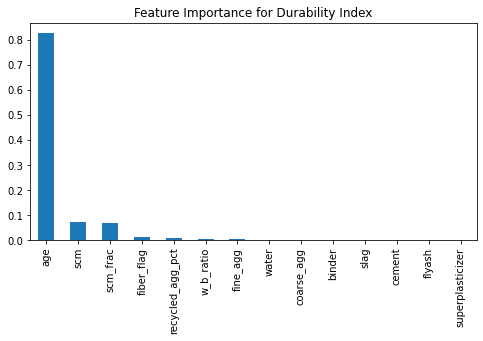

In [10]:
import matplotlib.pyplot as plt

importances = pd.Series(durability_model.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='bar', title='Feature Importance for Durability Index', figsize=(8,4))

In [11]:
joblib.dump(durability_model, '../models/durability_model.pkl')
print("✅ Durability model saved to ../models/durability_model.pkl")

✅ Durability model saved to ../models/durability_model.pkl
